In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import os
import mglearn

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 14

from sklearn import decomposition
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
DATA_PATH = "bankruptcy/train"
TEST_PATH = "bankruptcy/sample"

In [3]:
# all data files from each path stored in each dictionary
def data_reading(PATH):
    data_files = {}
    
    for file_name in os.listdir(PATH):
        print("Reading file: ", file_name)
        
        curr_table = pd.read_csv(os.path.join(PATH, file_name), index_col=['Id'], low_memory=False)
        curr_table.replace('?', np.nan, inplace = True)
        curr_table.iloc[:, :-1] = curr_table.iloc[:, :-1].astype(np.float64)
        
        # fill missing value with median
        imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
        curr_table.loc[:, curr_table.columns!='Bankrupt'] = imp_mean.fit_transform(curr_table.loc[:, curr_table.columns!='Bankrupt'])
        
        # save
        data_files[file_name[:-4]] = curr_table
    
    print("Finished Reading for Folder: ", PATH)
    return data_files

In [4]:
train_files = data_reading(DATA_PATH)

Reading file:  5th_yr.csv
Reading file:  1st_yr.csv
Reading file:  4th_yr.csv
Reading file:  3rd_yr.csv
Reading file:  2nd_yr.csv
Finished Reading for Folder:  bankruptcy/train


In [5]:
def perform_pca_for_a_year(year = '1st_yr'):
    data = train_files[year].copy()
    y = data.loc[:,'Bankrupt']
    X = data.loc[:, data.columns!='Bankrupt']
    # X = StandardScaler().fit_transform(X)

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X)
    principal_df = pd.DataFrame(data = principal_components, columns = ['principal component 1', 'principal component 2'])
    
    final_df = pd.concat([principal_df, data[['Bankrupt']]], axis = 1)
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [0, 1]
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        indices_to_keep = final_df['Bankrupt'] == target
        ax.scatter(final_df.loc[indices_to_keep, 'principal component 1'],
                   final_df.loc[indices_to_keep, 'principal component 2'],
                   c = color,
                   s = 50)
    ax.legend(targets)
    ax.grid()
    
    print("explained variance ratio:", pca.explained_variance_ratio_)

In [6]:
def drop_numerical_outliers(df, z_thresh=3):
    print('Before dropping outliers: ', df.shape)
    # Constrains will contain `True` or `False` depending on if it is a value below the threshold.
    constrains = df.iloc[:,:-1].select_dtypes(include=[np.number]) \
        .apply(lambda x: np.abs(stats.zscore(x)) < z_thresh) \
        .all(axis=1)
    print(constrains)
    # Drop (inplace) values set to be rejected
    df.drop(df.index[~constrains], inplace=True)
    print('After dropping outliers: ', df.shape)
    return df

In [7]:
def perform_pca_for_a_year(year = '1st_yr'):
    # https://stackoverflow.com/questions/65241847/how-to-plot-3d-pca-with-different-colors
    data = train_files[year].copy()
    data = drop_numerical_outliers(data, z_thresh=3)
    y = data.loc[:,'Bankrupt']
    X = data.loc[:, data.columns!='Bankrupt']
    sc = StandardScaler()

    scaler = StandardScaler()
    scaler.fit(X) 
    X_scaled = scaler.transform(X)

    pca = PCA(n_components=3)
    pca.fit(X_scaled) 
    X_pca = pca.transform(X_scaled)
    ex_variance=np.var(X_pca,axis=0)
    ex_variance_ratio = ex_variance/np.sum(ex_variance)
    ex_variance_ratio


    Xax = X_pca[:,0]
    Yax = X_pca[:,1]
    Zax = X_pca[:,2]

    cdict = {0:'red',1:'green'}
    labl = {0:'Fine',1:'Bankrupt'}
    marker = {0:'*',1:'o'}
    alpha = {0:.3, 1:.5}

    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111, projection='3d')

    fig.patch.set_facecolor('white')
    for l in np.unique(y):
        ix=np.where(y==l)
        ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40,
               label=labl[l], marker=marker[l], alpha=alpha[l])
    # for loop ends
    ax.set_xlabel("1st Principal Component", fontsize=14)
    ax.set_ylabel("2nd Principal Component", fontsize=14)
    ax.set_zlabel("3rd Principal Component", fontsize=14)

    ax.legend()
    plt.show()
    print("explained variance ratio:", pca.explained_variance_ratio_)

Before dropping outliers:  (5744, 65)
Id
3735    True
4564    True
6239    True
5877    True
2507    True
        ... 
6896    True
1970    True
5950    True
6724    True
5663    True
Length: 5744, dtype: bool
After dropping outliers:  (5454, 65)


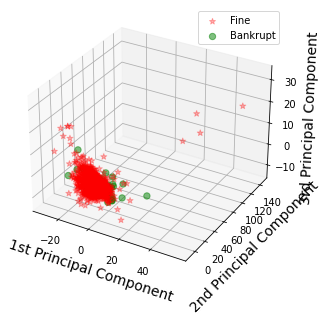

explained variance ratio: [0.22357694 0.1308106  0.08816755]


In [8]:
perform_pca_for_a_year('1st_yr')

Before dropping outliers:  (8314, 65)
Id
4090     True
4580     True
8015     True
8910     True
7361    False
        ...  
9786     True
8039     True
4600     True
6084     True
2612     True
Length: 8314, dtype: bool
After dropping outliers:  (8016, 65)


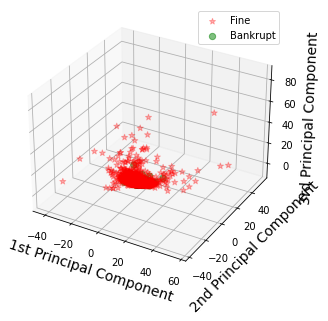

explained variance ratio: [0.19856797 0.10436708 0.07324557]


In [9]:
perform_pca_for_a_year('2nd_yr')

Before dropping outliers:  (8579, 65)
Id
9723      True
4645     False
6390      True
10139     True
3283      True
         ...  
6620      True
9763      True
2784      True
2270      True
8546      True
Length: 8579, dtype: bool
After dropping outliers:  (8189, 65)


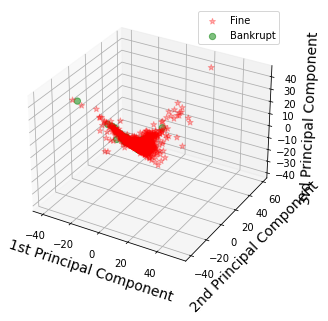

explained variance ratio: [0.20316614 0.095733   0.0688304 ]


In [10]:
perform_pca_for_a_year('3rd_yr')

Before dropping outliers:  (7995, 65)
Id
5365     True
9783     True
8441     True
6312     True
3517     True
        ...  
6658     True
3010     True
8955     True
6390    False
6345     True
Length: 7995, dtype: bool
After dropping outliers:  (7512, 65)


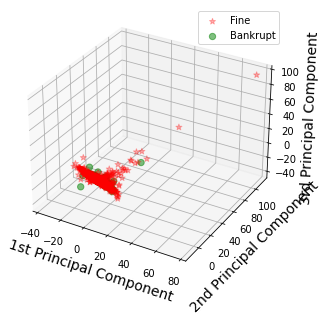

explained variance ratio: [0.18723226 0.11436622 0.08706304]


In [11]:
perform_pca_for_a_year('4th_yr')

Before dropping outliers:  (4818, 65)
Id
1188     True
1654     True
3864     True
3578     True
2028    False
        ...  
2337     True
2747     True
2982     True
1974    False
1505     True
Length: 4818, dtype: bool
After dropping outliers:  (4472, 65)


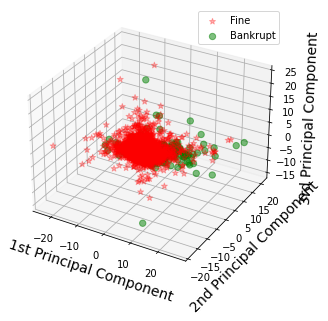

explained variance ratio: [0.25495724 0.10409674 0.065096  ]


In [12]:
perform_pca_for_a_year('5th_yr')

PCA PYTHON: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

EDA FEATURE SELECTION: https://www.visual-design.net/post/feature-selection-and-eda-in-machine-learning

<AxesSubplot:>

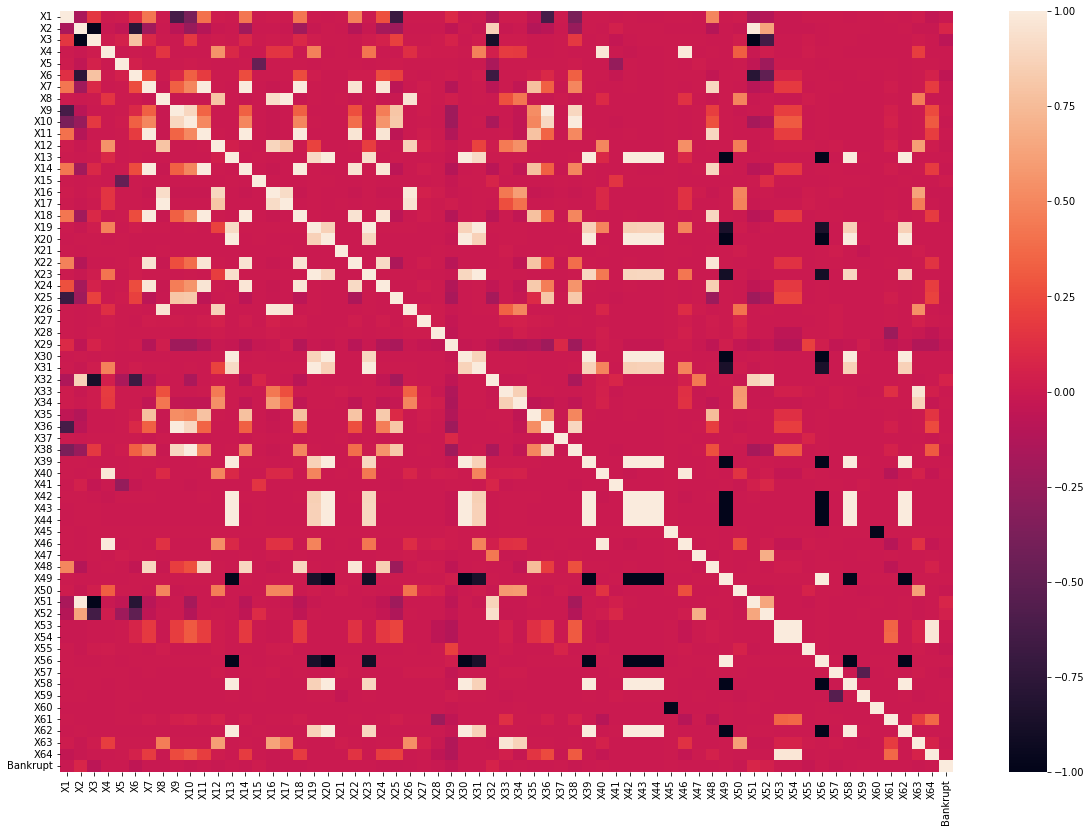

In [13]:
correlation = train_files['1st_yr'].corr()
sns.heatmap(correlation)

In [14]:
def feature_importance(year):
    from sklearn.feature_selection import mutual_info_classif
    data = train_files[year].copy()
    data = drop_numerical_outliers(data, z_thresh=3)
    y = data.loc[:,'Bankrupt']
    X = data.loc[:, data.columns!='Bankrupt']
    sc = StandardScaler()

    scaler = StandardScaler()
    scaler.fit(X) 
    X = scaler.transform(X)

    res = mutual_info_classif(X, y)
    feature_importance_df = pd.Series(res, data.columns[:len(data.columns)-1])
    feature_importance_df.plot(kind='barh')
    return feature_importance_df

Before dropping outliers:  (5744, 65)
Id
3735    True
4564    True
6239    True
5877    True
2507    True
        ... 
6896    True
1970    True
5950    True
6724    True
5663    True
Length: 5744, dtype: bool
After dropping outliers:  (5454, 65)


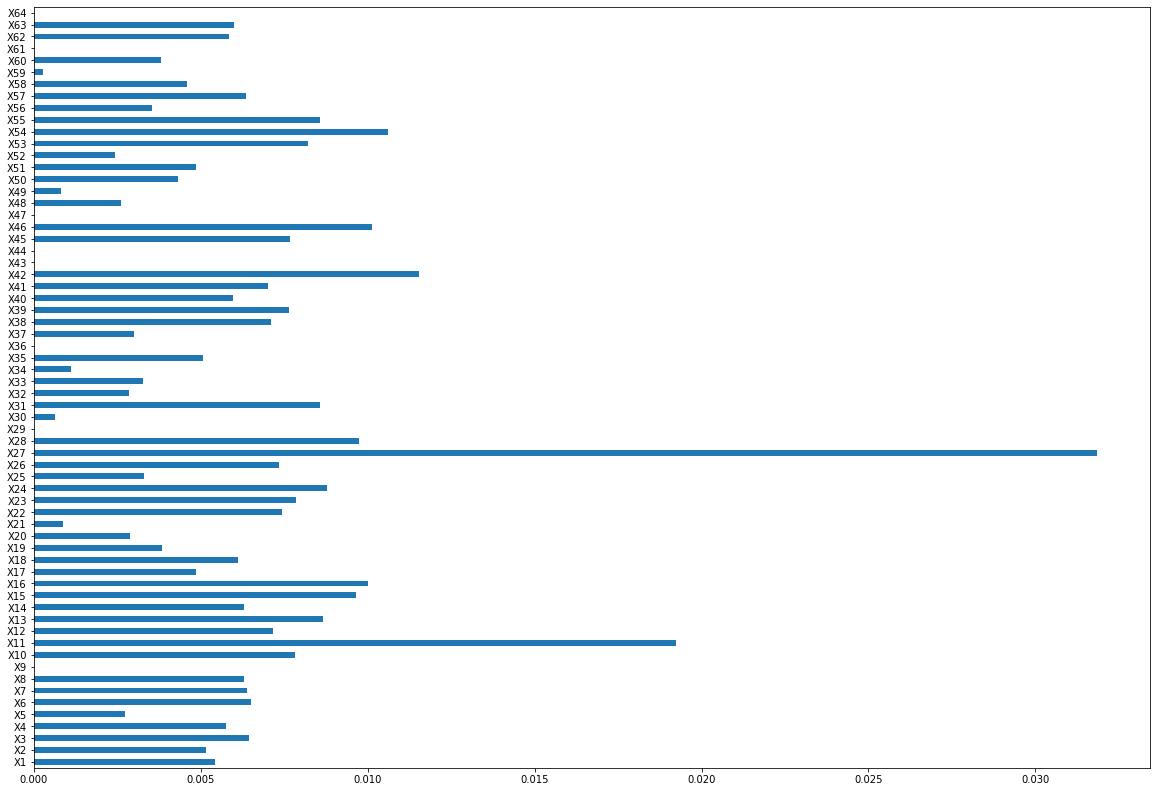

In [15]:
feature_importance_df_1st_year = feature_importance('1st_yr')

Before dropping outliers:  (8314, 65)
Id
4090     True
4580     True
8015     True
8910     True
7361    False
        ...  
9786     True
8039     True
4600     True
6084     True
2612     True
Length: 8314, dtype: bool
After dropping outliers:  (8016, 65)


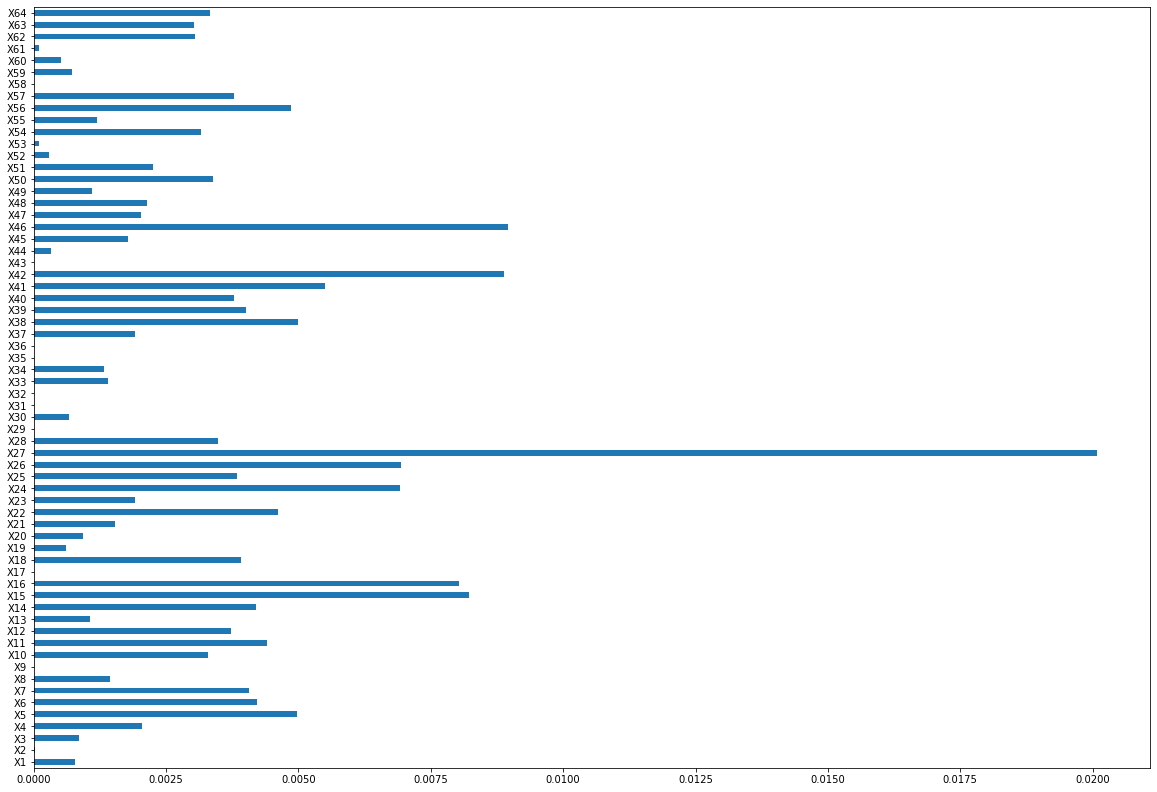

In [16]:
feature_importance_df_2nd_year = feature_importance('2nd_yr')

Before dropping outliers:  (8579, 65)
Id
9723      True
4645     False
6390      True
10139     True
3283      True
         ...  
6620      True
9763      True
2784      True
2270      True
8546      True
Length: 8579, dtype: bool
After dropping outliers:  (8189, 65)


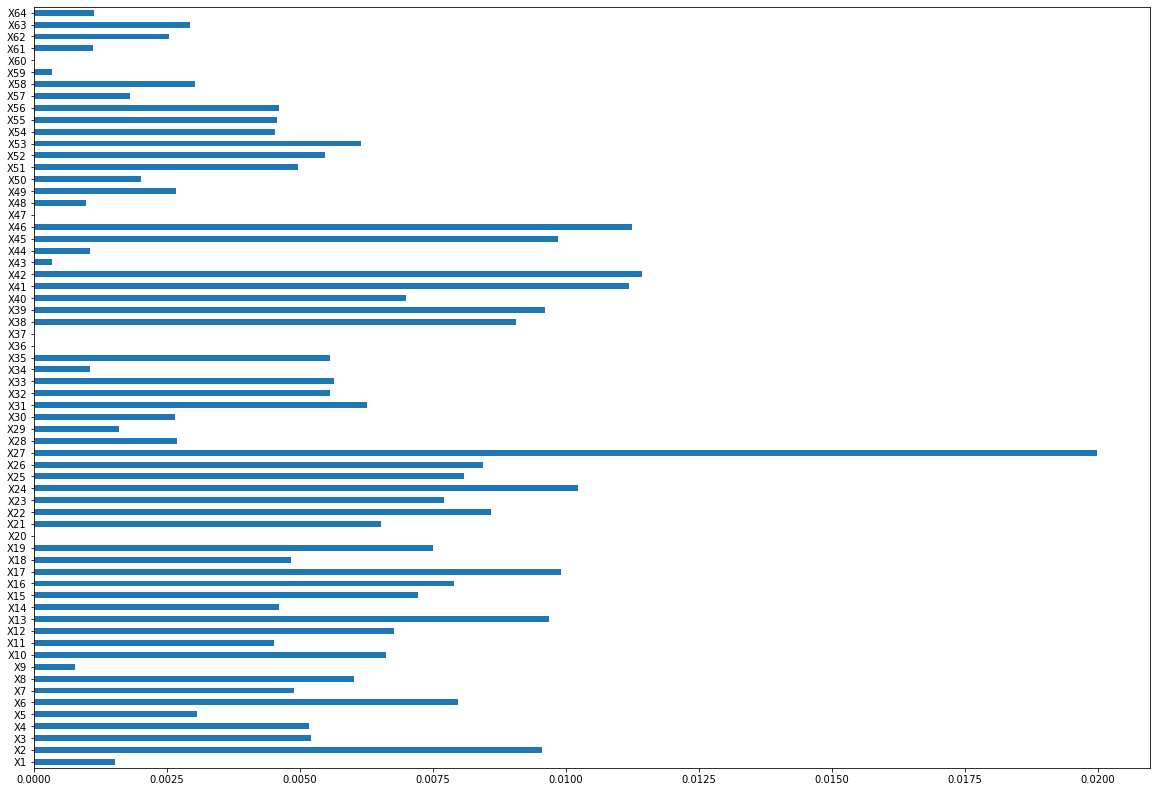

In [17]:
feature_importance_df_3rd_year = feature_importance('3rd_yr')

Before dropping outliers:  (7995, 65)
Id
5365     True
9783     True
8441     True
6312     True
3517     True
        ...  
6658     True
3010     True
8955     True
6390    False
6345     True
Length: 7995, dtype: bool
After dropping outliers:  (7512, 65)


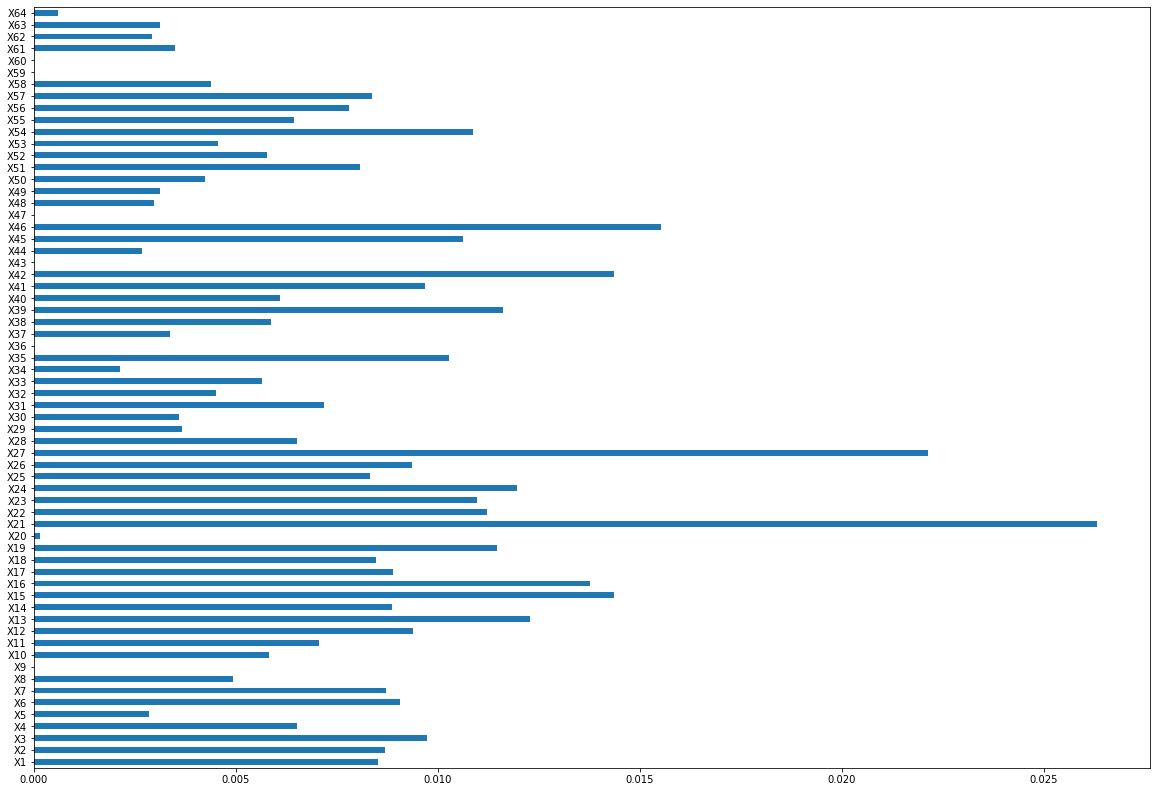

In [18]:
feature_importance_df_4th_year = feature_importance('4th_yr')

Before dropping outliers:  (4818, 65)
Id
1188     True
1654     True
3864     True
3578     True
2028    False
        ...  
2337     True
2747     True
2982     True
1974    False
1505     True
Length: 4818, dtype: bool
After dropping outliers:  (4472, 65)


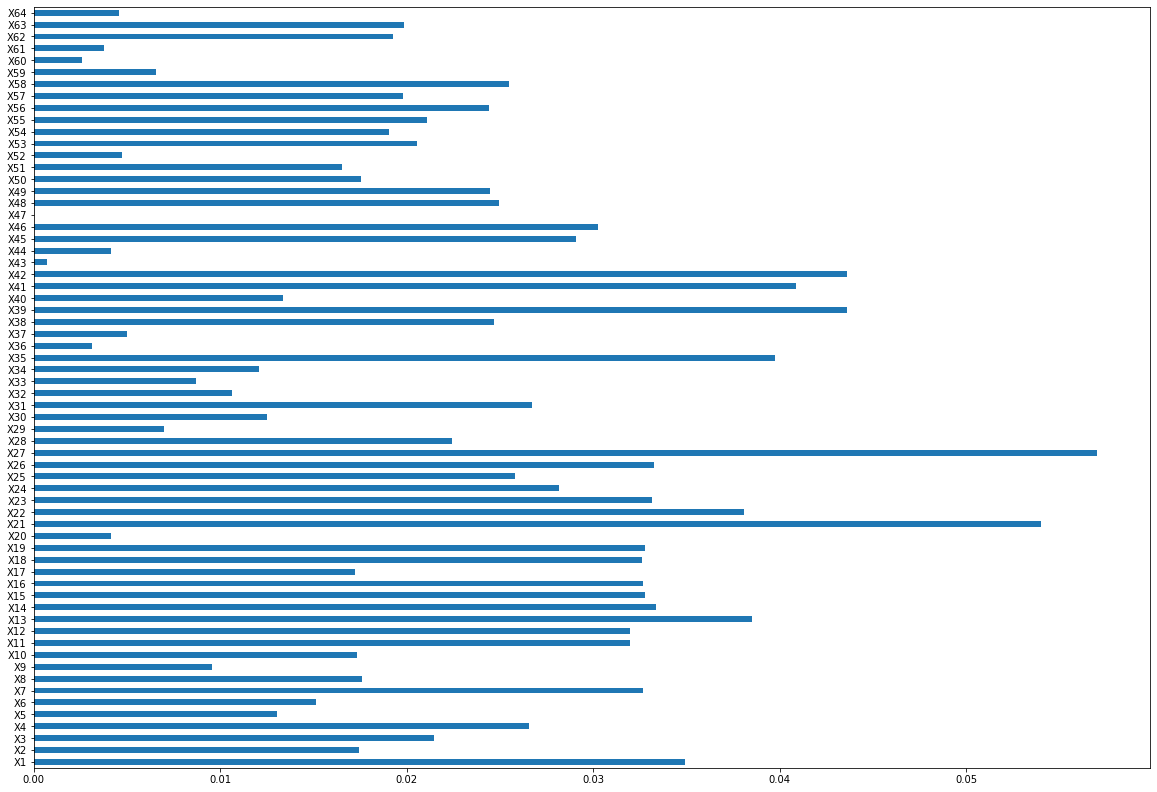

In [19]:
feature_importance_df_5th_year = feature_importance('5th_yr')

In [20]:
all_feature_importance = feature_importance_df_1st_year+feature_importance_df_2nd_year+feature_importance_df_3rd_year+feature_importance_df_4th_year+feature_importance_df_5th_year

In [21]:
all_feature_importance.sort_values(ascending=False)[:10]

X27    0.151032
X42    0.089820
X21    0.089228
X39    0.076498
X46    0.076092
X41    0.074251
X16    0.072373
X15    0.072230
X13    0.070212
X22    0.069963
dtype: float64

In [22]:
all_feature_importance.sort_values(ascending=True)[:10]

X43    0.001056
X47    0.002017
X36    0.003141
X60    0.006935
X59    0.007890
X20    0.008076
X44    0.008188
X61    0.008453
X64    0.009604
X9     0.010307
dtype: float64

Information gain is commonly used in the construction of decision trees from a training dataset, by evaluating the information gain for each variable, and selecting the variable that maximizes the information gain, which in turn minimizes the entropy and best splits the dataset into groups for effective classification.

Here we can observe that these features matter the most:
1. X27: profit on operating activities/financial expenses
2. X21: sales (n)/sales (n-1)
3. X42: profit on operating activities/sales

Here we can observe that these features matter the least:
1. X43: rotation receivables + inventory turnover in days
2. X47: (inventory * 365) / cost of products sold
3. X36: total sales/total assets

In [23]:
data = train_files['5th_yr'].copy()

In [25]:
data = drop_numerical_outliers(data)

Before dropping outliers:  (4818, 65)
Id
1188     True
1654     True
3864     True
3578     True
2028    False
        ...  
2337     True
2747     True
2982     True
1974    False
1505     True
Length: 4818, dtype: bool
After dropping outliers:  (4472, 65)


# YOU CAN PERFORM ANNOVA, OTHER WAYS TO FIND THE MOST IMPORTANT FEATURES
# MAKE MORE PLOTS